<big><big>**Лабораторная работа по теме: "Параллельное выполнение инструкций"**</big></big>

<big>Целью данной работы является изучение особенностей многопоточного и многопроцессного кода.</big>

<big>Для достижения поставленной цели необходимо решить следующие задачи:

Освоить написание многопоточного кода с синхронизацией.
    
Освоить написание многопроцессного кода с синхронизацией.
    
Сравнить производительность многопоточного и многопроцессного кода.</big>

<big>Ход работы:<big>

<big>

1. Создать программу, которая считывает последовательности из FASTA-файла.

2. Реализовать поиск и подсчет аминокислот по разным физико-химическим классам: гидрофобные, гиброфильные нейтральные, гидрофильные положительные, гидрофильные отрицательные.

3. Использовать сначала многопоточность, затем многопроцессность для параллельного анализа последовательностей.

3. Обеспечить синхронизацию потоков/процессов при подсчете общего количества найденных кодонов.</big>

<big>1. Код для деления исходного файла на части по 100, 1000, 10000 записей. </big>

In [ ]:
def split_fasta(input_file, record_counts, max_files=1):
    # открытие исходного FASTA файла в режиме чтения
    with open(input_file, 'r') as fasta_file:
        # чтение всего файла, strip - удаляет лишние пробелы, split - разрезает строку по символу
        records = fasta_file.read().strip().split('>')
        # теперь файл records содержит список, где каждый элемент содержит FASTA запись

    # уборка пустых записей (если они есть)
    records = [record for record in records if record]

    # перебор заданного количества записей и создание файлов
    for count in record_counts:
        # Ограничиваем количество файлов до max_files, len(records) // count - сколько файлов можно сделать с count записями в каждом
        num_files = min(max_files, len(records) // count)
        
        for i in range(num_files):
            # Формируем имя выходного файла
            output_file = f'C:\\Users\\sasha\\Downloads\\laba_1\\output_{count}_{i + 1}.fasta'
            
            # Записываем записи в файл
            with open(output_file, 'w') as out_file:
                # берем count записей и добавляем > в начало каждой записи как в FASTA
                out_file.write('>' + '>\n'.join(records[i * count:(i + 1) * count]))

# Задаем количество записей для каждого файла
record_counts = [100, 1000, 10000]

# путь к FASTA файлу
input_file = 'C:\\Users\\sasha\\Downloads\\uniprotkb_insulin_2025_02_07 (1).fasta'

# вызов функции
split_fasta(input_file, record_counts, max_files=1)

В результате образуется по 2 файла с разным количеством записей - 100, 1000, 10000

<big>2. Установка библиотеки.</big>

In [7]:
pip install biopython matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: C:\Users\sasha\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [8]:
pip install biopython

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: C:\Users\sasha\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [9]:
from Bio import SeqIO
import time
import threading
import queue
import matplotlib.pyplot as plt
import multiprocessing

<big>3. Однопоточный код, в результате которого рассчитывается количество разных классов аминокислот для последовательностей разной длины</big>

Обработано 100 записей за 0.10 секунд
Обработано 1000 записей за 0.41 секунд
Обработано 10000 записей за 2.18 секунд


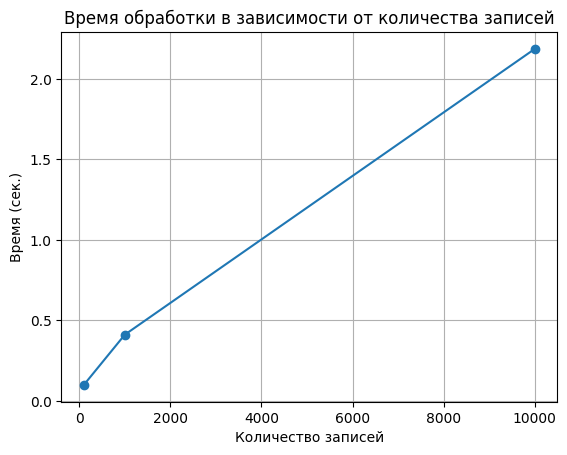

In [3]:
from Bio import SeqIO
import time
import matplotlib.pyplot as plt

class ProteinAnalyzer:
    def __init__(self, file_name):
        # file_name - пусть к FASTA файлу

        self.filename = file_name
        self.sequences = []  # Список для хранения последовательностей
        

        # Классификация аминокислот
        self.hydrophobic = {'A', 'V', 'I', 'L', 'M', 'F', 'W', 'P', 'G'}
        self.hydrophilic_neutral = {'S', 'T', 'C', 'N', 'Q', 'Y'}
        self.hydrophilic_positive = {'K', 'R', 'H'}
        self.hydrophilic_negative = {'D', 'E'}

    def read_fasta(self):

       # Чтение последовательностей из FASTA-файла.
       # парсим содержимое filename с помощью SeqIO.parse
        for seq_record in SeqIO.parse(self.filename, "fasta"):
            # добавление записей в self.sequences
            self.sequences.append(seq_record)
            
    def count_amino_acids(self, sequence):

       # Подсчет аминокислот по классам.
        counts = {
            "hydrophobic": 0,
            "hydrophilic_neutral": 0,
            "hydrophilic_positive": 0,
            "hydrophilic_negative": 0
        }

        # создание словаря counts, хранящий количество аминокислот в каждом классе
        for amino_acid in sequence:
            if amino_acid in self.hydrophobic:
                counts["hydrophobic"] += 1
            elif amino_acid in self.hydrophilic_neutral:
                counts["hydrophilic_neutral"] += 1
            elif amino_acid in self.hydrophilic_positive:
                counts["hydrophilic_positive"] += 1
            elif amino_acid in self.hydrophilic_negative:
                counts["hydrophilic_negative"] += 1
                
        return counts

    def analyze_sequences(self):

        # Анализ всех последовательностей в FASTA-файле.

        # создание пустого списка results для хранения результатов
        results = []
        for seq_record in self.sequences:
            seq_id = str(seq_record.id)
            sequence = str(seq_record.seq)  # Преобразуем Seq в строку
            counts = self.count_amino_acids(sequence) # подсчёт количества аминокислот
            results.append((seq_id, counts)) # добавление результата в results
        return results

def main():
    # Списки для хранения данных для графика
    input_sizes = []  # Количество записей
    times = []  # Время выполнения

    # Разные размеры входных данных (например, 100, 1000, 10000 записей)
    for size in [100, 1000, 10000]:
        # Вызов класса
        analyzer = ProteinAnalyzer(f"C:\\Users\\sasha\\Downloads\\laba_1\\output_{size}_1.fasta")

        # загружаем последовательности из анализируемого FASTA-файла
        analyzer.read_fasta()

        # Замер времени выполнения
        start_time = time.time()
        analyzer.analyze_sequences()
        end_time = time.time()

        # Данные для графика
        input_sizes.append(size)
        times.append(end_time - start_time)

        print(f'Обработано {size} записей за {end_time - start_time:.2f} секунд')

    # Построение графика
    plt.plot(input_sizes, times, marker='o')
    plt.title('Время обработки в зависимости от количества записей')
    plt.xlabel('Количество записей')
    plt.ylabel('Время (сек.)')
    plt.grid()
    plt.show()

if __name__ == "__main__":
    main()

<big> 4. Создание многопоточного кода для последовательностей со 100, 1000, 10000 записями. Расчёт времени и получение графика.</big>

100 записей - 0.12 секунд
1000 записей - 0.43 секунд
10000 записей - 2.48 секунд


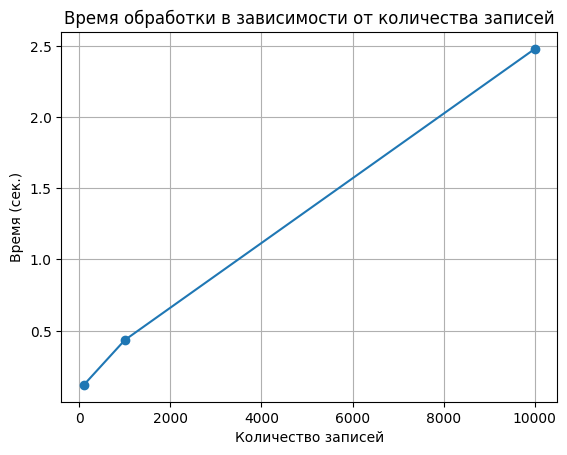

In [ ]:
from Bio import SeqIO
import time
from queue import Queue
import threading
import matplotlib.pyplot as plt

class ProteinAnalyzer:
    def __init__(self, file_name):
        self.filename = file_name
        self.sequences = []  # Список для хранения последовательностей

        # Классификация аминокислот
        self.hydrophobic = {'A', 'V', 'I', 'L', 'M', 'F', 'W', 'P', 'G'}
        self.hydrophilic_neutral = {'S', 'T', 'C', 'N', 'Q', 'Y'}
        self.hydrophilic_positive = {'K', 'R', 'H'}
        self.hydrophilic_negative = {'D', 'E'}

    def read_fasta(self):
        # Чтение последовательностей из FASTA-файла.
        for seq_record in SeqIO.parse(self.filename, "fasta"):
            self.sequences.append(seq_record)

    def count_amino_acids(self, sequence):
        # Подсчет аминокислот по классам.
        counts = {
            "hydrophobic": 0,
            "hydrophilic_neutral": 0,
            "hydrophilic_positive": 0,
            "hydrophilic_negative": 0
        }

        for amino_acid in sequence:
            if amino_acid in self.hydrophobic:
                counts["hydrophobic"] += 1
            elif amino_acid in self.hydrophilic_neutral:
                counts["hydrophilic_neutral"] += 1
            elif amino_acid in self.hydrophilic_positive:
                counts["hydrophilic_positive"] += 1
            elif amino_acid in self.hydrophilic_negative:
                counts["hydrophilic_negative"] += 1

        return counts

    def analyze_sequence(self, seq_record):
        # Анализ одной последовательности.
        seq_id = str(seq_record.id)
        sequence = str(seq_record.seq)  # Преобразуем Seq в строку
        counts = self.count_amino_acids(sequence)
        return (seq_id, counts)


class MyThread(threading.Thread):
    # создание класса MyThread, который наследуется от threading.Thread
    def __init__(self, queue, analyzer):
        threading.Thread.__init__(self)
        self.queue = queue # очередь задач
        self.analyzer = analyzer # объект ProteinAnalyzer

    def run(self):
    # обработка задач из очереди

        # пока очередь не пуста
        while not self.queue.empty():
            try:
                # берет элемент без ожидания
                seq_record = self.queue.get_nowait()

                # анализ последовательности
                self.analyzer.analyze_sequence(seq_record)

                # помечает задачу как выполненную
                self.queue.task_done()

            except queue.Empty:
                break


def process_sequences(file_name):

    """
    Функция для обработки последовательностей с использованием многопоточности.
    Возвращает время выполнения.
    """
    analyzer = ProteinAnalyzer(file_name)
    analyzer.read_fasta()

    # создание очереди задач
    task_queue = Queue()

    # добавление всех последовательностей в очередь
    for seq_record in analyzer.sequences:
        task_queue.put(seq_record)

    threads = [] # создание пустого списка для хранения потоков
    start_time = time.time()
    for _ in range(4): # запуск 4 потоков

        # каждый поток берет задачи из task_queue и выполянет анализ
        thread = MyThread(task_queue, analyzer)
        threads.append(thread)
        thread.start()

    # ожидание завершения всех потоков
    for thread in threads:
        thread.join()

    end_time = time.time()
    return end_time - start_time


def Plot():
    sizes = []  
    times = [] 

    for size in [100, 1000, 10000]:
        file_name = f"C:\\Users\\sasha\\Downloads\\laba_1\\output_{size}_1.fasta"
        
        # Обрабатываем последовательности и замеряем время
        elapsed_time = process_sequences(file_name)
        
        # Сохраняем данные для графика
        sizes.append(size)
        times.append(elapsed_time)

        print(f'{size} записей - {elapsed_time:.2f} секунд')

    # Строим график
    plt.plot(sizes, times, marker='o')
    plt.title('Время обработки в зависимости от количества записей')
    plt.xlabel('Количество записей')
    plt.ylabel('Время (сек.)')
    plt.grid()
    plt.show()


if __name__ == "__main__":
    Plot()

<big> 5. Создание многопроцессорного кода для последовательностей со 100, 1000, 10000 записями. Расчёт времени и получение графика.</big>

In [ ]:
from Bio import SeqIO
import time
import multiprocessing
import matplotlib.pyplot as plt

class ProteinAnalyzer:
    def __init__(self, file_name):
        self.filename = file_name
        self.sequences = []

        self.hydrophobic = {'A', 'V', 'I', 'L', 'M', 'F', 'W', 'P', 'G'}
        self.hydrophilic_neutral = {'S', 'T', 'C', 'N', 'Q', 'Y'}
        self.hydrophilic_positive = {'K', 'R', 'H'}
        self.hydrophilic_negative = {'D', 'E'}

    def read_fasta(self):
        """Чтение последовательностей из FASTA-файла."""
        self.sequences = list(SeqIO.parse(self.filename, "fasta"))

    def count_amino_acids(self, sequence):
        """Подсчет аминокислот по классам."""
        counts = {
            "hydrophobic": 0,
            "hydrophilic_neutral": 0,
            "hydrophilic_positive": 0,
            "hydrophilic_negative": 0
        }

        for amino_acid in sequence:
            if amino_acid in self.hydrophobic:
                counts["hydrophobic"] += 1
            elif amino_acid in self.hydrophilic_neutral:
                counts["hydrophilic_neutral"] += 1
            elif amino_acid in self.hydrophilic_positive:
                counts["hydrophilic_positive"] += 1
            elif amino_acid in self.hydrophilic_negative:
                counts["hydrophilic_negative"] += 1

        return counts


def analyze_sequence(seq_record):

    # Функция для многопроцессорного анализа одной последовательности

    sequence = str(seq_record.seq) # преобразование последовательности в строку
    analyzer = ProteinAnalyzer("")  # Временный объект для доступа к подсчёту
    return (seq_record.id, analyzer.count_amino_acids(sequence)) # возвращаем кортеж, где seq_record.id - ID, analyzer.count_amino_acids(sequence) возвращает словарь с подсчитанными АК


def process_sequences(file_name, num_workers=4):

    # Обработка последовательностей с использованием multiprocessing.Pool.map

    analyzer = ProteinAnalyzer(file_name)
    analyzer.read_fasta()

    start_time = time.time()

    # создание пула процессов
    with multiprocessing.Pool(processes=num_workers) as pool:
        results = pool.map(analyze_sequence, analyzer.sequences) # pool.map - распределяет задачи между процессами

    end_time = time.time()
    return end_time - start_time, results


def Plot():
    sizes = []
    times = []

    for size in [100, 1000, 10000]:
        file_name = f"C:\\Users\\sasha\\Downloads\\laba_1\\output_{size}_1.fasta"
        
        elapsed_time, _ = process_sequences(file_name)
        
        sizes.append(size)
        times.append(elapsed_time)

        print(f'Обработано с помощью процессов {size} записей - {elapsed_time:.2f} секунд')

    plt.plot(sizes, times, marker='o')
    plt.title('Время обработки в зависимости от количества записей')
    plt.xlabel('Количество записей')
    plt.ylabel('Время (сек.)')
    plt.grid()
    plt.show()


if __name__ == "__main__":
    Plot()

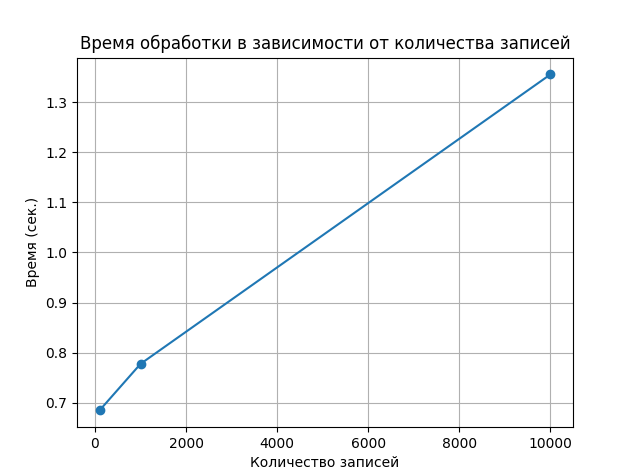

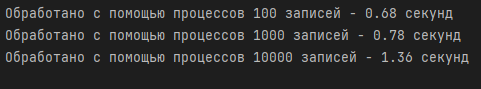

 <big> 6. Расчёт времени выполнения однопоточного кода для полного файла </big>

In [5]:
from Bio import SeqIO
import time
import matplotlib.pyplot as plt

class ProteinAnalyzer:
    def __init__(self, file_name):
  
        self.filename = file_name
        self.sequences = []  # Список для хранения последовательностей
        self.sec_id = ''

        # Классификация аминокислот
        self.hydrophobic = {'A', 'V', 'I', 'L', 'M', 'F', 'W', 'P', 'G'}
        self.hydrophilic_neutral = {'S', 'T', 'C', 'N', 'Q', 'Y'}
        self.hydrophilic_positive = {'K', 'R', 'H'}
        self.hydrophilic_negative = {'D', 'E'}

    def read_fasta(self):
   
        for seq_record in SeqIO.parse(self.filename, "fasta"):
            self.sequences.append(seq_record)
            
    def count_amino_acids(self, sequence):
  
        counts = {
            "hydrophobic": 0,
            "hydrophilic_neutral": 0,
            "hydrophilic_positive": 0,
            "hydrophilic_negative": 0
        }

        for amino_acid in sequence:
            if amino_acid in self.hydrophobic:
                counts["hydrophobic"] += 1
            elif amino_acid in self.hydrophilic_neutral:
                counts["hydrophilic_neutral"] += 1
            elif amino_acid in self.hydrophilic_positive:
                counts["hydrophilic_positive"] += 1
            elif amino_acid in self.hydrophilic_negative:
                counts["hydrophilic_negative"] += 1
                
        return counts

    def analyze_sequences(self):


        results = []
        for seq_record in self.sequences:
            seq_id = str(seq_record.id)
            sequence = str(seq_record.seq)
            counts = self.count_amino_acids(sequence)
            results.append((seq_id, counts))
        return results

def main():


    # Инициализация анализатора
    analyzer = ProteinAnalyzer(f"C:\\Users\\sasha\\Downloads\\uniprotkb_insulin_2025_02_07.fasta")

    # Чтение FASTA-файла
    analyzer.read_fasta()

    # Замер времени выполнения
    start_time = time.time()
    analyzer.analyze_sequences()
    end_time = time.time()

    print(f'Обработан первоначальный файл за {end_time - start_time:.2f} секунд')


if __name__ == "__main__":
    main()


Обработан первоначальный файл за 15.47 секунд


<big> 7. Расчёт времени и построение графика, отражающего зависимость времени от числа потоков в многопоточном коде.</big>

1 поток - 21.30 секунд
2 потоков - 21.94 секунд
4 потоков - 21.09 секунд
8 потоков - 21.62 секунд


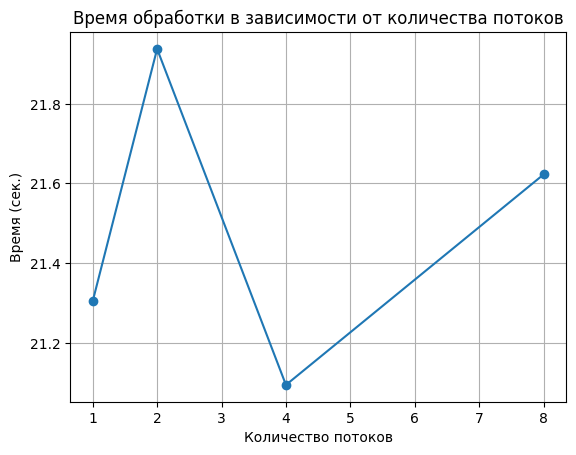

In [ ]:
from Bio import SeqIO
import time
from queue import Queue
import threading
import matplotlib.pyplot as plt

class ProteinAnalyzer:
    def __init__(self, file_name):
        self.filename = file_name
        self.sequences = []  # Список для хранения последовательностей

        # Классификация аминокислот
        self.hydrophobic = {'A', 'V', 'I', 'L', 'M', 'F', 'W', 'P', 'G'}
        self.hydrophilic_neutral = {'S', 'T', 'C', 'N', 'Q', 'Y'}
        self.hydrophilic_positive = {'K', 'R', 'H'}
        self.hydrophilic_negative = {'D', 'E'}

    def read_fasta(self):
        # Чтение последовательностей из FASTA-файла.
        for seq_record in SeqIO.parse(self.filename, "fasta"):
            self.sequences.append(seq_record)

    def count_amino_acids(self, sequence):
        # Подсчет аминокислот по классам.
        counts = {
            "hydrophobic": 0,
            "hydrophilic_neutral": 0,
            "hydrophilic_positive": 0,
            "hydrophilic_negative": 0
        }

        for amino_acid in sequence:
            if amino_acid in self.hydrophobic:
                counts["hydrophobic"] += 1
            elif amino_acid in self.hydrophilic_neutral:
                counts["hydrophilic_neutral"] += 1
            elif amino_acid in self.hydrophilic_positive:
                counts["hydrophilic_positive"] += 1
            elif amino_acid in self.hydrophilic_negative:
                counts["hydrophilic_negative"] += 1

        return counts

    def analyze_sequence(self, seq_record):

        # Анализ одной последовательности.
        seq_id = str(seq_record.id)
        sequence = str(seq_record.seq)  # Преобразуем Seq в строку
        counts = self.count_amino_acids(sequence)
        return (seq_id, counts)


class MyThread(threading.Thread):
    def __init__(self, queue, analyzer):
        threading.Thread.__init__(self)
        self.queue = queue
        self.analyzer = analyzer

    def run(self):
        while not self.queue.empty():
            try:
                # Берем задачу из очереди
                seq_record = self.queue.get_nowait()
                # Анализируем последовательность
                self.analyzer.analyze_sequence(seq_record)
                # Помечаем задачу как выполненную
                self.queue.task_done()
            except queue.Empty:
                break


def process_sequences(file_name):

    analyzer = ProteinAnalyzer(file_name)
    analyzer.read_fasta()

    # Создаем очередь задач
    task_queue = Queue()
    for seq_record in analyzer.sequences:
        task_queue.put(seq_record)

    # Создаем и запускаем потоки
    threads = []
    start_time = time.time()
    for _ in range(4):
        thread = MyThread(task_queue, analyzer)
        threads.append(thread)
        thread.start()

    # Ожидаем завершения всех потоков
    for thread in threads:
        thread.join()

    end_time = time.time()
    return end_time - start_time


def main():
    sizes = []  
    times = [] 

    # теперь только один исходный файл 
    file_name = "C:\\Users\\sasha\\Downloads\\uniprotkb_insulin_2025_02_07.fasta"
    
    # и разное количество потоков
    for num_threads in [1, 2, 4, 8]:

        # обрабатываем последовательности и замеряем время
        elapsed_time = process_sequences(file_name)
        
        sizes.append(num_threads)
        times.append(elapsed_time)

        if num_threads == 1:
            print(f'{num_threads} поток - {elapsed_time:.2f} секунд')
        else:
            print(f'{num_threads} потоков - {elapsed_time:.2f} секунд')   

    plt.plot(sizes, times, marker='o')
    plt.title('Время обработки в зависимости от количества потоков')
    plt.xlabel('Количество потоков')
    plt.ylabel('Время (сек.)')
    plt.grid()
    plt.show()

    


if __name__ == "__main__":
    Plot()

<big> 8. Расчёт времени и построение графика, отражающего зависимость времени от числа процессов в многопроцессорном коде.</big>

In [ ]:
from Bio import SeqIO
import time
import multiprocessing
import matplotlib.pyplot as plt

class ProteinAnalyzer:
    def __init__(self, file_name):
        self.filename = file_name
        self.sequences = []

        self.hydrophobic = {'A', 'V', 'I', 'L', 'M', 'F', 'W', 'P', 'G'}
        self.hydrophilic_neutral = {'S', 'T', 'C', 'N', 'Q', 'Y'}
        self.hydrophilic_positive = {'K', 'R', 'H'}
        self.hydrophilic_negative = {'D', 'E'}

    def read_fasta(self):
        """Чтение последовательностей из FASTA-файла."""
        self.sequences = list(SeqIO.parse(self.filename, "fasta"))

    def count_amino_acids(self, sequence):
        """Подсчет аминокислот по классам."""
        counts = {
            "hydrophobic": 0,
            "hydrophilic_neutral": 0,
            "hydrophilic_positive": 0,
            "hydrophilic_negative": 0
        }

        for amino_acid in sequence:
            if amino_acid in self.hydrophobic:
                counts["hydrophobic"] += 1
            elif amino_acid in self.hydrophilic_neutral:
                counts["hydrophilic_neutral"] += 1
            elif amino_acid in self.hydrophilic_positive:
                counts["hydrophilic_positive"] += 1
            elif amino_acid in self.hydrophilic_negative:
                counts["hydrophilic_negative"] += 1

        return counts


def analyze_sequence(seq_record):
    """Функция для многопроцессорного анализа одной последовательности."""
    sequence = str(seq_record.seq)
    analyzer = ProteinAnalyzer("")  # Временный объект для доступа к классификации аминокислот
    return (seq_record.id, analyzer.count_amino_acids(sequence))


def process_sequences(file_name, num_workers=4):
    """Обработка последовательностей с использованием multiprocessing.Pool.map."""
    analyzer = ProteinAnalyzer(file_name)
    analyzer.read_fasta()

    start_time = time.time()

    # Создаем пул процессов и распараллеливаем анализ последовательностей
    with multiprocessing.Pool(processes=num_workers) as pool:
        results = pool.map(analyze_sequence, analyzer.sequences)

    end_time = time.time()
    return end_time - start_time, results


def Plot():
    sizes = []
    times = []

    # один файл
    file_name = "C:\\Users\\sasha\\Downloads\\uniprotkb_insulin_2025_02_07.fasta"
    
    # аналогично разное количество процессов
    for num_proc in [1, 2, 4, 8]:

        elapsed_time = process_sequences(file_name)
        
        sizes.append(num_proc)
        times.append(elapsed_time)

        if num_proc == 1:
            print(f'{num_threads} процесс - {elapsed_time:.2f} секунд')
        else:
            print(f'{num_threads} процессов - {elapsed_time:.2f} секунд')   

    plt.plot(sizes, times, marker='o')
    plt.title('Время обработки в зависимости от количества потоков')
    plt.xlabel('Количество потоков')
    plt.ylabel('Время (сек.)')
    plt.grid()
    plt.show()


if __name__ == "__main__":
    Plot()

Результаты с pycharm (т.к. VS отказывается мне давать ответ)

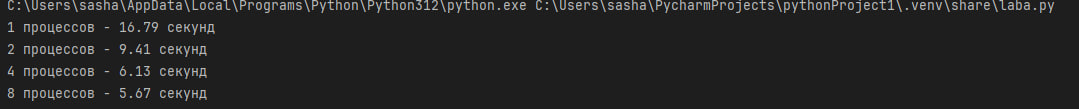

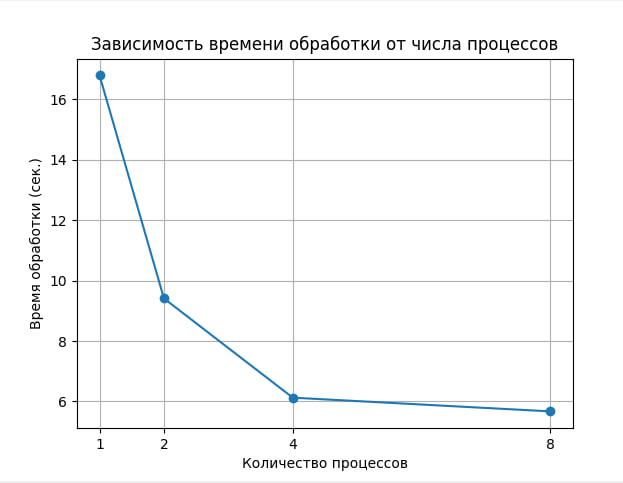

<big>**Результаты:**</big>


1. Результаты были следующими: маленькие файлы (100, 1000 записей) были быстрее обработаны в однопоточном и многопоточном коде, но большие файлы (10000 и исходный) быстрее выполнились в многопроцессорном. Вероятно это связано с тем, что создание процессов и обмен между ними сообщениями, занимает больше времени, чем обработка маленьких файлов.
2. Многопоточный код выполнялся медленнее однопоточного, а при увеличении количества потоков время выполнения практически не менялось. Вероятно это связано с наличием очереди queue или с наличием GIL, который разрешает выполнение в момент времени только одного потока.
3. При увеличении числа процессов в многопроцессорном коде время уменьшалось, так как количество процессоров (ядер), на которые был распараллелен код, увеличивалось.

<big>**Вывод:**</big>

1. Был изучен и написан код с использованием модуля threading
2. Был изучен и написан код с использованием модуля multiproccessing
3. Время выполнения кода для исходного файла с использование модуля multiproccessing было меньше, чем для выполнения кода с использованием модуля threading. Притом при увеличении числа потоков, время выполнения кода не уменьшалось, а при увеличении числа процессов, как и ожидалось, затраченное время уменьшалось.